# Datacamp Courses - Machine Learning and Time Series Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [83]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from functools import partial

In [2]:
url = 'https://assets.datacamp.com/production/repositories/1536/datasets/43d325fa67cde1d4d5de62adc108fceabaddf3cc/prices.csv'
Prices = pd.read_csv(url)

### 2 Variables

In [32]:
Pricesp = Prices[(Prices.symbol == 'EBAY') | (Prices.symbol == 'YHOO')]
prices = Pricesp.pivot(index = 'date', columns = 'symbol', values = 'close')
prices.index = pd.to_datetime(prices.index)
prices.head(3)

symbol,EBAY,YHOO
date,,
2010-01-04,23.90,17.10
2010-01-05,23.65,17.23
2010-01-06,23.50,17.17


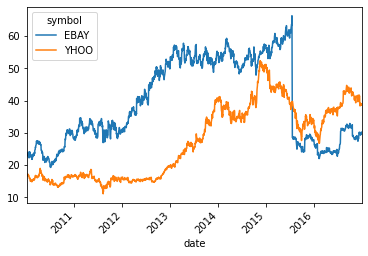

In [27]:
prices.plot()
plt.xticks(rotation = 45)
plt.show()

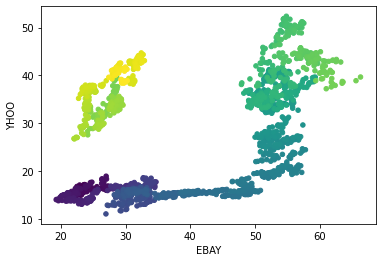

In [28]:
prices.plot.scatter('EBAY', 'YHOO', c = prices.index, cmap=plt.cm.viridis, colorbar=False)
plt.show()

### Multiple Variables and Regression

Data has been purposefully changed so that regression score (below) and plot are off compared to Datacamp exercise

In [72]:
all_prices = Prices.pivot(index = 'date', columns = 'symbol', values = 'close')
all_prices.index = pd.to_datetime(all_prices.index)

all_prices = all_prices[all_prices.index <= '2015-01-30']

X = all_prices[['EBAY','NVDA','YHOO']]
y = all_prices[['AAPL']]
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-6.09050633 -0.3179172  -3.72957284]


-0.3380697256228935


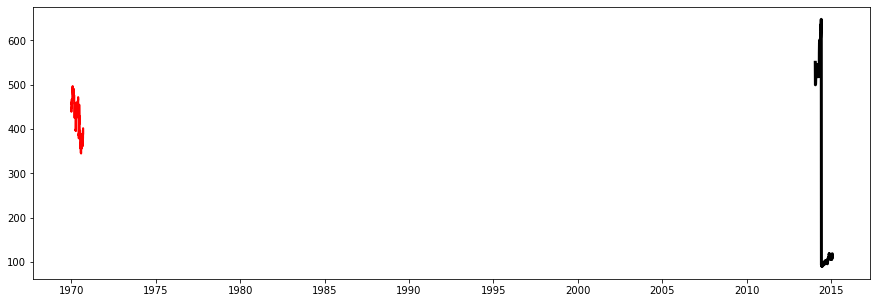

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, shuffle=False, random_state=1)
model = Ridge()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)
print(score)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(y_test, color='k', lw=3)
ax.plot(y_pred, color='r', lw=2)
plt.show()

### Handling Missing Data and Outliers

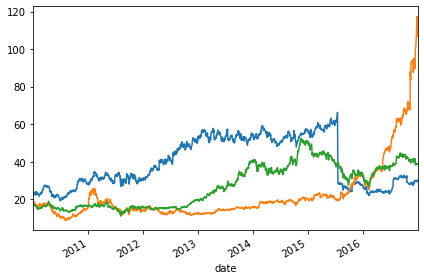

symbol
EBAY    0
NVDA    0
YHOO    0
dtype: int64


In [81]:
Pricesp = Prices[(Prices.symbol == 'EBAY') | (Prices.symbol == 'NVDA') | (Prices.symbol == 'YHOO')]
prices = Pricesp.pivot(index = 'date', columns = 'symbol', values = 'close')
prices.index = pd.to_datetime(prices.index)

prices.plot(legend=False)
plt.tight_layout()
plt.show()

# Count the missing values of each time series
missing_values = prices.isna().sum()
print(missing_values)

In [82]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()
    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)
    plt.show()

# Intrpolate using the latest non-missing value or linear or quadratic
interpolation_type = 'zero'  # 'linear' 'quadratic'
interpolate_and_plot(prices, interpolation_type)

In [ ]:
# Visualizing outliers by percent changes

def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

# Apply your custom function and plot
prices_perc = prices.rolling(20).apply(percent_change)
prices_perc.loc["2014":"2015"].plot()
plt.show()

In [ ]:
# Replacing outliers

def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.apply(replace_outliers)
prices_perc.loc["2014":"2015"].plot()
plt.show()

### Smoothing data

In [ ]:
# Engraging multiple features at once, for smoothing of a time series

# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6))
plt.show()

In [ ]:
# Similarly, you can extract Percentiles of a time series using Partials

# Percentiles to consider
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5))
plt.show()

In [85]:
# Extract information from time series date

# Extract date features from the data, add them as columns
prices_perc['day_of_week'] = prices_perc.index.dayofweek
prices_perc['week_of_year'] = prices_perc.index.weekofyear
prices_perc['month_of_year'] = prices_perc.index.month

# Print prices_perc
print(prices_perc)